In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

In [25]:
def save_in_folder(folder_name, file_name):
    try:
        plt.savefig(os.path.join(folder_name, file_name), frameon=True, bbox_inches='tight')
    except FileNotFoundError:
        os.mkdir(folder_name)
        plt.savefig(os.path.join(folder_name, file_name), frameon=True, bbox_inches='tight')

In [2]:
df = pd.read_json(os.path.join('input', 'train.json'))
shape = (75,75)

In [3]:
for band in ['band_1', 'band_2']:
    df[band] = df[band].apply(np.asarray)
df.loc[df['inc_angle'] == 'na', 'inc_angle'] = np.nan

In [4]:
df['angle_NaN'] = df.inc_angle.isnull()

In [5]:
df['category'] = df.is_iceberg.apply(lambda row: 'ships' if row == 0 else 'icebergs')

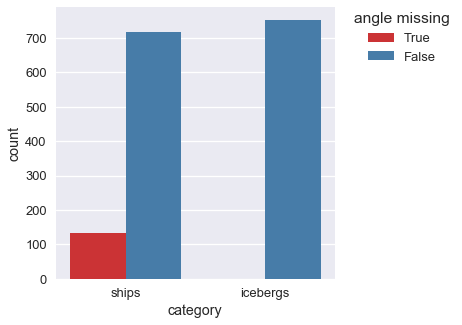

In [26]:
sns.set(context='talk', style='darkgrid')
plt.figure(figsize=(5,5))
sns.countplot(x='category', hue='angle_NaN', data=df, palette='Set1', hue_order=[True, False]);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='angle missing');
save_in_folder('capstone_report', 'angle_na_count.png')

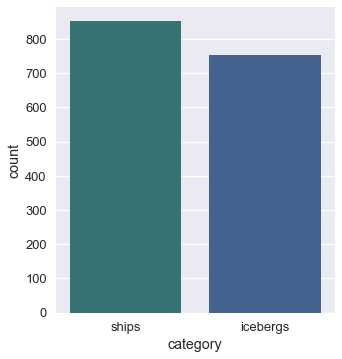

In [27]:
plt.figure(figsize=(5,5*(9/8)))
sns.countplot(x='category', data=df, palette='winter_r', saturation=.35);
save_in_folder('capstone_report', 'train_data_dist.png')

In [8]:
iceberg = df[df.is_iceberg == 1].sample(1).iloc[0].band_1

In [9]:
iceberg = scale(iceberg)

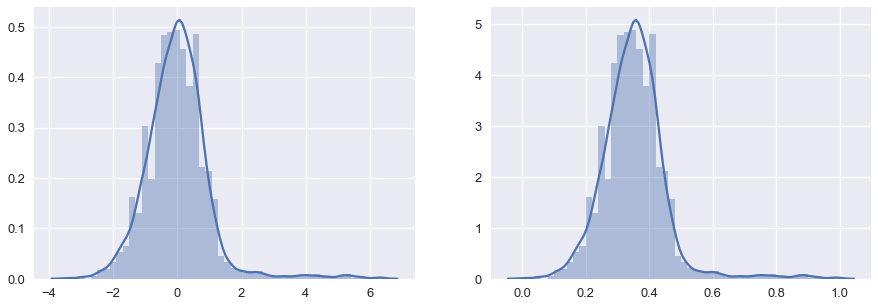

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(iceberg);

def mima(arr):
    return (arr - arr.min()) / abs(arr.max() - arr.min())

plt.subplot(122)
minimax = mima(iceberg)
sns.distplot(minimax);

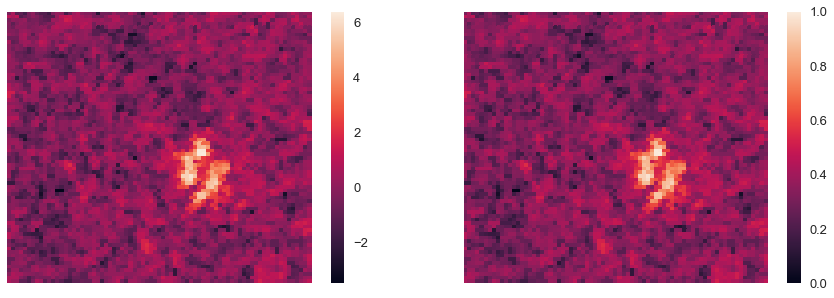

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(121)
iceberg2d = iceberg.reshape(75,75)
sns.heatmap(iceberg2d, xticklabels=False, yticklabels=False);
plt.subplot(122)
minmax2d = minimax.reshape(75,75)
sns.heatmap(minmax2d, xticklabels=False, yticklabels=False);

In [12]:
from functools import reduce

def L(x):
    return 1 + np.log(x) if x > 1 else x

def bentes_norm(arr):
    Larr = np.fromiter((L(x) for x in arr), dtype=arr.dtype, count=reduce(lambda a,b: a*b, arr.shape))
    maxL = abs(Larr.max())
    return Larr / maxL

In [28]:
tbentes = 'bentes normalized dB'
tnorm = 'normalized dB'

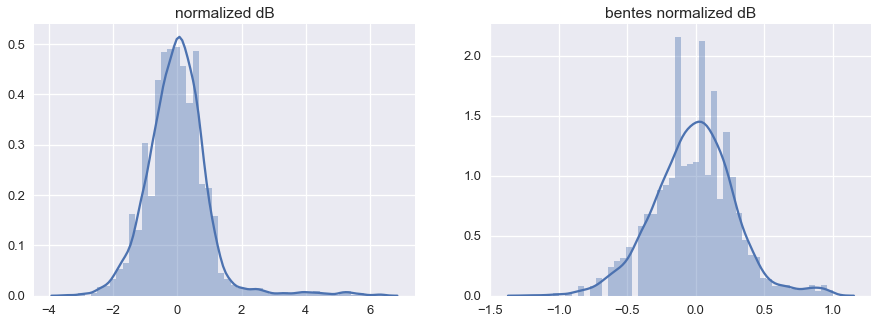

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(iceberg)
plt.title(tnorm)
plt.subplot(122)
bentes = bentes_norm(iceberg)
plt.title(tbentes)
sns.distplot(bentes);

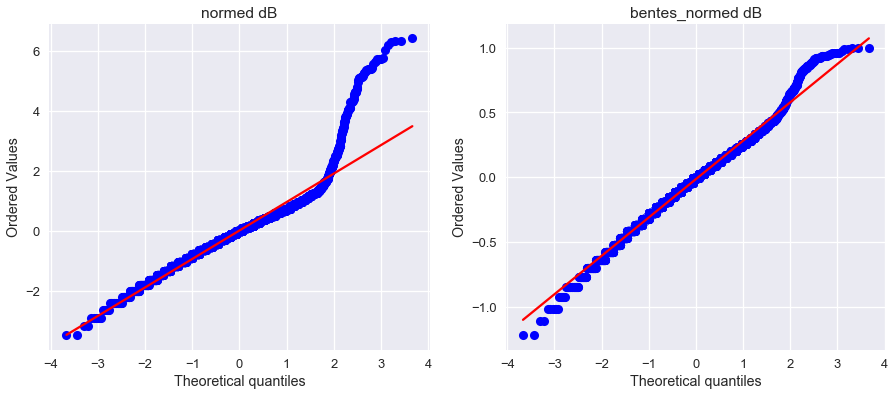

In [15]:
from scipy import stats

plt.figure(figsize=(15,6))
plt.subplot(121)
stats.probplot(iceberg, plot=plt)
plt.title(tnorm)
plt.subplot(122)
stats.probplot(bentes, plot=plt)
plt.title(tbentes)
plt.show()

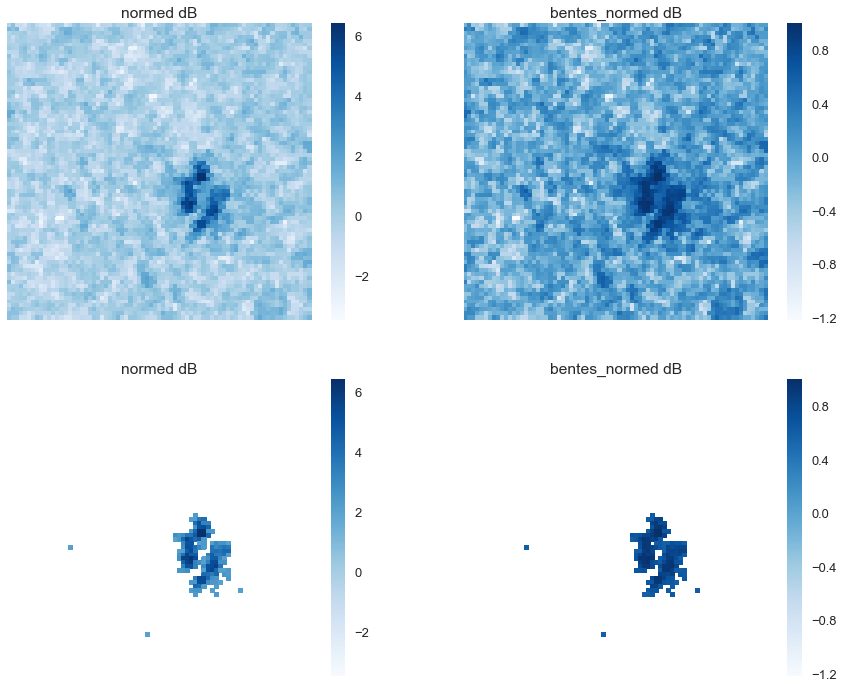

In [16]:
bentes2d = bentes.reshape(75,75)
ice2d = iceberg.reshape(75,75)

mask = lambda arr: arr < arr.mean() + 2*arr.std()
cmap = 'Blues'
with sns.axes_style('white'):
    plt.figure(figsize=(15,12))
    plt.subplot(221)
    sns.heatmap(ice2d, xticklabels=False, yticklabels=False, cmap=cmap)
    plt.title(tnorm)
    plt.subplot(223)
    sns.heatmap(ice2d, xticklabels=False, yticklabels=False, mask=mask(ice2d), cmap=cmap)
    plt.title(tnorm)
    plt.subplot(222)
    sns.heatmap(bentes2d, xticklabels=False, yticklabels=False, cmap=cmap)
    plt.title(tbentes)
    plt.subplot(224)
    sns.heatmap(bentes2d, xticklabels=False, yticklabels=False, mask=mask(bentes2d), cmap=cmap)
    plt.title(tbentes)
    plt.show()

In [17]:
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)


def plot_3d_example(band_data, name):
    surface = go.Surface(
            z=band_data,
            colorbar={'title': 'dB'}
        )
    data = [surface]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [18]:
print(0.0 if np.isclose(iceberg.mean(), 0) else iceberg.mean(), iceberg.std())
plot_3d_example(ice2d, tnorm)

0.0 1.0


In [19]:
print(bentes.mean(), bentes.std())
plot_3d_example(bentes2d, tbentes)

-0.014533354763739566 0.2976036039757306


###### Incidence Angle

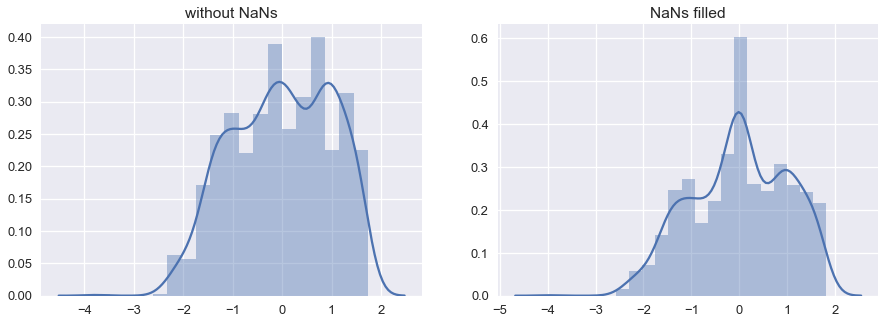

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(121)
dropped_angle = df.inc_angle.dropna().astype(float)
sns.distplot(scale(dropped_angle));
plt.title('without NaNs')
plt.subplot(122)
filled_angle = df.inc_angle.fillna(df.inc_angle.mean())
sns.distplot(scale(filled_angle));
plt.title('NaNs filled')
plt.show()

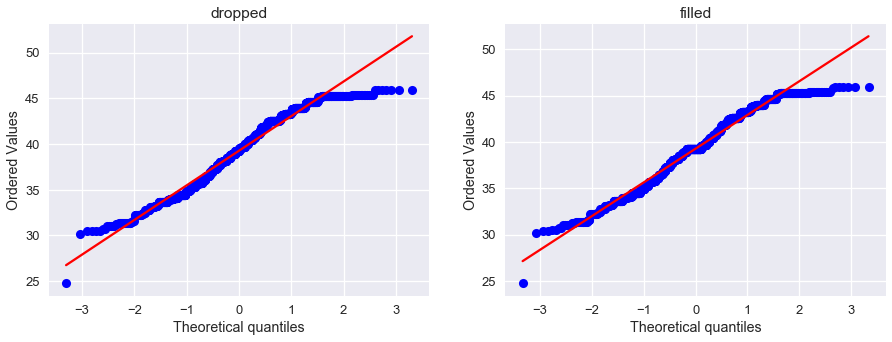

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(121)
stats.probplot(dropped_angle, plot=plt)
plt.title('dropped')
plt.subplot(122)
stats.probplot(filled_angle, plot=plt)
plt.title('filled')
plt.show()

In [22]:
df[df.inc_angle == df.inc_angle.min()].index[0]

1021

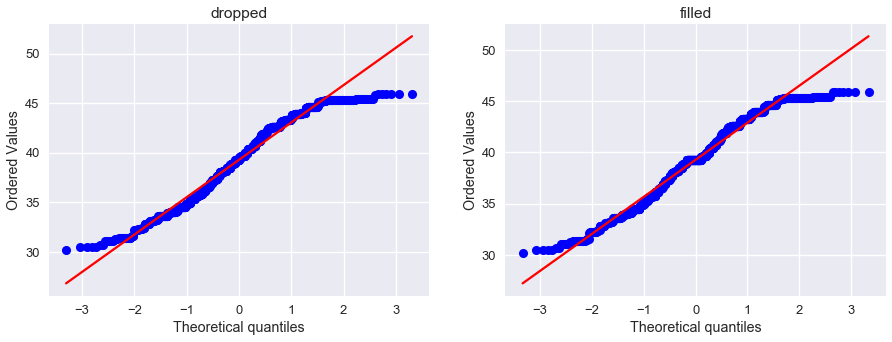

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(121)
stats.probplot((dropped_angle.drop(df[df.inc_angle == df.inc_angle.min()].index[0])), plot=plt)
plt.title('dropped')
plt.subplot(122)
stats.probplot(filled_angle.drop(df[df.inc_angle == df.inc_angle.min()].index[0]), plot=plt)
plt.title('filled')
plt.show()